## CONFIGURACIÓN DEL ENTORNO E INFRAESTRUCTURA DE DATOS

Esta seccion es la declaración de infraestructura del notebook.

1. **Cumplimiento Arquitectura**: Define dinámicamente dónde vive el "Data Lake" (carpetas data/01_bronze y data/02_silver) sin importar en qué computadora corra el código.

2. **Cumplimiento Quants**: Prepara las herramientas estadísticas (scipy.stats) para desarrollar las pruebas de normalidad.

3. **Cumplimiento Data Engineering**: Configura el formato visual y asegura que existan los directorios para el almacenamiento *Schema-on-Read*.

### Importacion de librerias

In [25]:
import os
import sys
import requests
import warnings
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats  # Requerido por Specs de Quants (Test de Normalidad)
from dotenv import load_dotenv
import bcchapi
import time
from pathlib import Path
from datetime import datetime
import seaborn as sns
import json

### Configuracion de alertas y estilo visual

In [2]:
warnings.filterwarnings('ignore')  # Ignorar advertencias no críticas
sns.set_style("whitegrid")         # Estilo profesional para gráficos financieros
plt.rcParams['figure.figsize'] = (12, 6)

### Definicion de arquitectura de Datos (LakeHouse)

In [3]:
# Deteccion la raíz del proyecto subiendo un nivel desde la carpeta 'notebooks'
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
# Definición de rutas según el estándar Medallion (Informe Data Eng N°4)
DATA_DIR = os.path.join(BASE_DIR, "data")
BRONZE_DIR = os.path.join(DATA_DIR, "01_bronze")  # Raw Data (Inmutable)
SILVER_DIR = os.path.join(DATA_DIR, "02_silver")  # Curated Data (Limpia/Parquet)

### Defensa de infraestructura

In [4]:
# Se crea las carpetas automáticamente si no existen (Idempotencia)
for directory in [BRONZE_DIR, SILVER_DIR]:
    os.makedirs(directory, exist_ok=True)

# Validación de Rutas
print(f"✅ Entorno Iniciado Correctamente")
print(f"📂 Raíz del Proyecto: {BASE_DIR}")
print(f"🗄️  Bronze Layer (Raw): {BRONZE_DIR}")
print(f"🗄️  Silver Layer (Curated): {SILVER_DIR}")

✅ Entorno Iniciado Correctamente
📂 Raíz del Proyecto: /home/puya-chilensis/CL-RiskEngine
🗄️  Bronze Layer (Raw): /home/puya-chilensis/CL-RiskEngine/data/01_bronze
🗄️  Silver Layer (Curated): /home/puya-chilensis/CL-RiskEngine/data/02_silver


## DEFINICIÓN DEL UNIVERSO DE ACTIVOS Y VENTANA TEMPORAL

Explicación Técnica y Alineación con la Documentación:

1. **Contexto Chileno:** Seleccionamos activos locales clave que cotizan en la Bolsa de Santiago pero que son accesibles vía Yahoo Finance (.SN para Santiago).

   - BCH.SN: Banco de Chile (Sector financiero/IPSA).

   - SQM-B.SN: Sociedad Química y Minera (Commodities/Litio).

   - COPEC.SN: Empresas Copec (Industrial/Energía).

2. **Benchmark Internacional:** Incluimos el ^GSPC (S&P 500) para medir la correlación con mercados globales, un requisito implícito en el **Informe de Quants** para entender factores de riesgo externos.

3. **Ventana Temporal:** Definimos un periodo que incluya volatilidad (desde 2020), fundamental para que la **Capa Bronce** tenga datos de "estrés" para las simulaciones de Monte Carlo.

### Definición de Tickers (Enfoque Chile + Global)

**Rigor**: Al separar tickers_chile de tickers_global, se prepara el terreno para análisis de "Beta" y exposición por mercado.

In [5]:
# Se usa el sufijo .SN para la Bolsa de Santiago vía Yahoo Finance
tickers_chile = ['BCH.SN', 'SQM-B.SN', 'COPEC.SN'] 
tickers_global = ['^GSPC'] # Benchmark S&P 500

UNIVERSO = tickers_chile + tickers_global

### Definición de Fechas

In [6]:
# Iniciamos en 2020 para capturar la volatilidad de la pandemia y eventos locales
FECHA_INICIO = "2020-01-01"
FECHA_FIN = "2025-01-31" # Ajustado a la última actualización

### Metadatos del Portafolio (Para futuras auditorías)

In [7]:
print(f"✅ Universo de activos definido:")
print(f"   🇨🇱 Chile: {tickers_chile}")
print(f"   🌎 Global: {tickers_global}")
print(f"   📅 Periodo: {FECHA_INICIO} hasta {FECHA_FIN}")

✅ Universo de activos definido:
   🇨🇱 Chile: ['BCH.SN', 'SQM-B.SN', 'COPEC.SN']
   🌎 Global: ['^GSPC']
   📅 Periodo: 2020-01-01 hasta 2025-01-31


**Seguridad**: El assert garantiza que no se intenta correr un modelo de correlación (Cholesky) con un solo activo, lo cual rompería el motor matemático definido en tu **Informe de Quants**.

In [8]:
# Verificación de consistencia del universo
assert len(UNIVERSO) > 1, "El universo debe contener múltiples activos para calcular correlaciones (Cholesky)."

## DESARROLLO DE LAYER BRONZE

### INGESTA OFICIAL BANCO CENTRAL DE CHILE (SIETES API)

1. **Capa Bronce (Data Eng Spec):** Se guarda la respuesta de la API directamente en un archivo Parquet inmutable.

2. **Seguridad:** Usamos python-dotenv para cargar las variables al entorno del sistema.

3. **Manejo de Nulos:** Si la API falla, devolvemos un DataFrame vacío para que el pipeline no colapse (Graceful Degradation). 

4. **Identificadores de Serie:** Uso de los códigos oficiales del BCCH:

   - ``F073.UFF.PRE.Z.D``: Unidad de Fomento (UF) diaria.

   - ``F073.TCO.PRE.Z.D``: Tipo de Cambio (Dólar Observado).

5. **Resiliencia (HPC):** La función de descarga incluye manejo de errores y tiempos de espera (`timeout`) para evitar que el pipeline se bloquee si la API del Banco Central está saturada.

6. **Seguridad de Datos:** Se usa ``os.path.join`` con ``BRONZE_DIR``. Esta siendo fieles a tu árbol de directorios. No esta "ensuciando" la carpeta raíz con archivos temporales.

7. ***Schema-on-Read:*** Solo convierte la fecha y el valor a número. No esta eliminando nulos ni ajustando feriados todavía. Eso ocurrirá en la Capa Silver.

8. **Importancia para el Quant:** El valor de la UF es clave porque muchos activos chilenos (como bonos o contratos de energía) se valorizan en UF. Si quieres calcular el VaR (Value at Risk) real, debes considerar cómo se mueve la UF respecto a las acciones.

#### Configuracion y carga de crendeciales

In [9]:
BASE_DIR = Path(os.getcwd()).parent
ENV_PATH = BASE_DIR / ".env"

print(f"🔍 Buscando .env en: {ENV_PATH.resolve()}")

if ENV_PATH.exists():
    load_dotenv(ENV_PATH, override=True)
    print("✅ Archivo .env detectado.")
else:
    print("⚠️ ADVERTENCIA CRÍTICA: No se encontró el archivo .env")

BCCH_USER = os.getenv("BCCH_USER")
BCCH_PASS = os.getenv("BCCH_PASS")

🔍 Buscando .env en: /home/puya-chilensis/CL-RiskEngine/.env
✅ Archivo .env detectado.


#### Funcion de extraccion 

In [10]:
def fetch_bcch_data(user: str, password: str, series_code: str, label: str, retries: int = 3) -> pd.DataFrame:
    if not user or not password:
        print(f"⚠️ [SKIP] Faltan credenciales para {label}.")
        return pd.DataFrame()

    for attempt in range(1, retries + 1):
        try:
            siete = bcchapi.Siete(user, password)
            print(f"🔄 [{attempt}/{retries}] Descargando {label} ({series_code})...")
            
            df = siete.cuadro(
                series=[series_code],
                nombres=[label],
                desde=FECHA_INICIO,
                hasta=FECHA_FIN,
                frecuencia="D",
                observado={label: "last"}  
            )
            
            if df.empty:
                print(f"⚠️ La API respondió OK pero sin datos para {label}.")
                return df
                
            df.index.name = 'fecha'
            print(f"✅ {label} descargado correctamente ({len(df)} registros).")
            return df

        except Exception as e:
            print(f"❌ Error intento {attempt} para {label}: {e}")
            if attempt < retries:
                time.sleep(2)
            else:
                print(f"💀 Fallo definitivo para {label} tras {retries} intentos.")
                return pd.DataFrame()

#### Ejecucion 

In [11]:
CODIGO_UF = "F073.UFF.PRE.Z.D"
CODIGO_DOLAR = "F073.TCO.PRE.Z.D"

df_uf = fetch_bcch_data(BCCH_USER, BCCH_PASS, CODIGO_UF, "UF")
df_usd = fetch_bcch_data(BCCH_USER, BCCH_PASS, CODIGO_DOLAR, "USD_OBS")

🔄 [1/3] Descargando UF (F073.UFF.PRE.Z.D)...
✅ UF descargado correctamente (1858 registros).
🔄 [1/3] Descargando USD_OBS (F073.TCO.PRE.Z.D)...
✅ USD_OBS descargado correctamente (1857 registros).


#### Guardado en Capa Bronze

In [12]:
os.makedirs(BRONZE_DIR, exist_ok=True)

if not df_uf.empty:
    path_uf = Path(BRONZE_DIR) / "bcch_uf_raw.parquet"
    df_uf.reset_index().to_parquet(path_uf)
    print(f"💾 UF guardada en: {path_uf}")

if not df_usd.empty:
    path_usd = Path(BRONZE_DIR) / "bcch_usd_raw.parquet"
    df_usd.reset_index().to_parquet(path_usd)
    print(f"💾 Dólar guardado en: {path_usd}")

💾 UF guardada en: /home/puya-chilensis/CL-RiskEngine/data/01_bronze/bcch_uf_raw.parquet
💾 Dólar guardado en: /home/puya-chilensis/CL-RiskEngine/data/01_bronze/bcch_usd_raw.parquet


#### VALIDACIÓN DE Bronze Layer (SANITY CHECK)

In [13]:
print("🔎 Iniciando auditoría de archivos Parquet...")

try:
    path_uf = os.path.join(BRONZE_DIR, "bcch_uf_raw.parquet")
    path_usd = os.path.join(BRONZE_DIR, "bcch_usd_raw.parquet")
    
    # 1. Cargar archivos
    df_uf_check = pd.read_parquet(path_uf)
    df_usd_check = pd.read_parquet(path_usd)

    if 'fecha' in df_uf_check.columns:
        df_uf_check = df_uf_check.set_index('fecha')
    
    if 'fecha' in df_usd_check.columns:
        df_usd_check = df_usd_check.set_index('fecha')
        
    df_uf_check.index = pd.to_datetime(df_uf_check.index)
    df_usd_check.index = pd.to_datetime(df_usd_check.index)

    print(f"\n✅ UF Cargada: {df_uf_check.shape[0]} registros")
    print(f"   Rango Fechas: {df_uf_check.index.min().date()} a {df_uf_check.index.max().date()}")
    print("   Últimos 3 valores:")
    print(df_uf_check.tail(3))

    print(f"\n✅ USD Cargado: {df_usd_check.shape[0]} registros")
    print(f"   Rango Fechas: {df_usd_check.index.min().date()} a {df_usd_check.index.max().date()}")
    print("   Últimos 3 valores:")
    print(df_usd_check.tail(3))
    
    delta_dias = abs((df_uf_check.index.max() - df_usd_check.index.max()).days)
    if delta_dias > 5:
        print(f"\n⚠️ ALERTA: Hay un desfase de {delta_dias} días entre la data de UF y Dólar.")
    else:
        print(f"\n✨ Sincronización temporal OK (Desfase: {delta_dias} días)")

except Exception as e:
    print(f"❌ Error leyendo Parquet: {e}")
    # Tip de debugging: Imprimir columnas si falla para ver qué nombre tienen
    if 'df_uf_check' in locals():
        print(f"   Columnas disponibles en UF: {df_uf_check.columns.tolist()}")

🔎 Iniciando auditoría de archivos Parquet...

✅ UF Cargada: 1858 registros
   Rango Fechas: 2020-01-01 a 2025-01-31
   Últimos 3 valores:
                  UF
fecha               
2025-01-29  38389.36
2025-01-30  38386.88
2025-01-31  38384.41

✅ USD Cargado: 1857 registros
   Rango Fechas: 2020-01-02 a 2025-01-31
   Últimos 3 valores:
            USD_OBS
fecha              
2025-01-29   992.07
2025-01-30   990.94
2025-01-31   988.10

✨ Sincronización temporal OK (Desfase: 0 días)


### INGESTA DE MERCADO (Yahoo Finance) Bronze Layer

Hasta ahora se tiene la **Macroeconomía** (UF y Dólar oficial), pero un motor de riesgo se necesita **Activos Financieros** reales para simular. Esta celda descarga los precios históricos de las acciones donde el banco/fondo tiene invertido dinero.

**Especificaciones Técnicas (A partir de la documentacion tecnica con base bibliografica):**

1. **Fuente (Adapters):** Se usa la librería `yfinance` para conectarse a la API pública de Yahoo Finance.
2. **Universo (Quants Spec):**
* **Chile (`.SN`):** `BCH.SN` (Banco de Chile), `SQM-B.SN` (Soquimich), `COPEC.SN` (Copec). Estos representan riesgos locales (sector bancario, minería, energía).
* **Global (`^GSPC`):** S&P 500. Sirve de "Benchmark" para medir cómo nos afecta el riesgo sistémico mundial.
3. **Ingeniería de Datos (Data Eng Spec):**
* **Raw Data:** Se descarga el dato "crudo".
* **Ajuste Corporativo:** USa `auto_adjust=True` para que los precios incluya dividendos y splits (crucial para calcular retornos reales).
* **Persistencia:** Se guarda en **Parquet** dentro de `data/01_bronze`, particionado por la fecha de ejecución (para no sobrescribir historia).


In [14]:
# Objetivo: Descargar precios de acciones chilenas y benchmark global.

import yfinance as yf
from datetime import datetime

print("📥 Iniciando descarga de acciones desde Yahoo Finance...")

# 1. DEFINICIÓN DEL UNIVERSO CORREGIDO
# Cambio: Reemplazamos 'BCH.SN' por 'CHILE.SN' (Banco de Chile)
# Yahoo a veces cambia los tickers locales.
TICKERS = ['CHILE.SN', 'SQM-B.SN', 'COPEC.SN', '^GSPC'] 

# 2. DESCARGA MASIVA
try:
    print(f"🔎 Buscando tickers: {TICKERS}")
    
    # Descarga
    raw_market_data = yf.download(
        TICKERS, 
        start=FECHA_INICIO, 
        end=FECHA_FIN, 
        auto_adjust=True,
        progress=False
    )['Close'] # Solo precios de cierre

    # Validación de Integridad
    if raw_market_data.empty:
        raise ValueError("❌ Yahoo Finance devolvió un dataset vacío.")
    
    # Se verifica las columnas reales (Evitar falsos positivos)
    # Se elimina la columna que sean todo NaN (tickers fallidos)
    raw_market_data = raw_market_data.dropna(axis=1, how='all')
    
    descargados = raw_market_data.columns.tolist()
    if not descargados:
         raise ValueError("❌ Se descargó el objeto, pero todas las columnas están vacías (Tickers incorrectos).")

    print(f"✅ Activos validados y descargados: {descargados}")

    # 3. PERSISTENCIA EN CAPA BRONZE
    today_str = datetime.now().strftime('%Y%m%d')
    filename = f"market_data_raw_{today_str}.parquet"
    file_path = os.path.join(BRONZE_DIR, filename)

    # CORRECCIÓN TÉCNICA: Usamos engine='pyarrow' explícitamente
    # Esto evita el error "type extension already defined"
    raw_market_data.to_parquet(file_path, engine='pyarrow')

    print("-" * 50)
    print(f"📦 CAPA BRONZE (RENTA VARIABLE) ACTUALIZADA")
    print(f"   📍 Archivo guardado: {filename}")
    print(f"   📉 Activos Guardados: {descargados}")
    print(f"   📊 Dimensiones: {raw_market_data.shape}")
    print("-" * 50)

except Exception as e:
    print(f"❌ Error crítico en descarga de mercado: {e}")
    # Tip de debug para el usuario
    if "pandas.period" in str(e):
        print("💡 TIP: Reinicia el Kernel de Jupyter (Kernel -> Restart) y vuelve a intentar.")

📥 Iniciando descarga de acciones desde Yahoo Finance...
🔎 Buscando tickers: ['CHILE.SN', 'SQM-B.SN', 'COPEC.SN', '^GSPC']
✅ Activos validados y descargados: ['CHILE.SN', 'COPEC.SN', 'SQM-B.SN', '^GSPC']
--------------------------------------------------
📦 CAPA BRONZE (RENTA VARIABLE) ACTUALIZADA
   📍 Archivo guardado: market_data_raw_20260205.parquet
   📉 Activos Guardados: ['CHILE.SN', 'COPEC.SN', 'SQM-B.SN', '^GSPC']
   📊 Dimensiones: (1314, 4)
--------------------------------------------------


## SILVER LAYER (UNIFICACIÓN Y RETORNOS)

**Objetivo:** Cruzar datos Macro + Mercado y calcular retornos logarítmicos.

Se tiene los dos parquet separadas en la carpeta 01_bronze:

1. Macroeconomía: UF y Dólar (del Banco Central).
2. Mercado: Acciones y S&P 500 (de Yahoo).

Aquí se fusiona todo en una "Tabla Maestra" para calcular los Retornos Logarítmicos (el input matemático real para los modelos).

### Carga de datos desde Bronze 

Se usa pathlib para encontrar los archivos sin importar el nombre exacto de la fecha


In [15]:
try:
    # A) Datos Macro (Banco Central)
    # Lectura y respaldo que el índice sea la fecha
    df_uf = pd.read_parquet(os.path.join(BRONZE_DIR, "bcch_uf_raw.parquet"))
    df_usd = pd.read_parquet(os.path.join(BRONZE_DIR, "bcch_usd_raw.parquet"))
    
    # Si al guardar se reseteó el índice, se restaura
    if 'fecha' in df_uf.columns: df_uf = df_uf.set_index('fecha')
    if 'fecha' in df_usd.columns: df_usd = df_usd.set_index('fecha')

    # B) Datos Mercado (Yahoo)
    # Busqueda del archivo más reciente que empiece con "market_data_raw"
    files = [f for f in os.listdir(BRONZE_DIR) if f.startswith("market_data_raw")]
    if not files:
        raise FileNotFoundError("❌ No se encontró el archivo de mercado en Bronze.")
    
    # Se Ordena para tomar el último generado
    latest_file = sorted(files)[-1]
    print(f"   📂 Usando archivo de mercado: {latest_file}")
    
    path_market = os.path.join(BRONZE_DIR, latest_file)
    df_market = pd.read_parquet(path_market)

except Exception as e:
    print(f"❌ Error cargando archivos Bronze: {e}")
    raise e

   📂 Usando archivo de mercado: market_data_raw_20260205.parquet


### Merge en la fusión de fuentes 

Se aplica la estrategia de Left Join sobre el Mercado <br>
Si la bolsa esta cerrada (feriado o fines de semana), no se simula ese dia, aunque haya dato de UF 

In [16]:
df_master = df_market.join(df_uf, how='left').join(df_usd, how='left')

### Limpieza y Data Quality (EXtraido desde el informe Data Engineering)

In [17]:
# Regla: Forward Fill (Rellenar hacia adelante).
# Si es feriado en Chile y no hay UF/Dólar ese día, se asume el valor del día anterior.
df_master = df_master.ffill()

# Regla: Drop NaNs. Eliminamos el inicio de la historia si algún activo no existía aún.
df_master = df_master.dropna()

print(f"✅ Tabla Maestra generada. Dimensiones: {df_master.shape}")

✅ Tabla Maestra generada. Dimensiones: (1314, 6)


### Calculo de retronos logarítmicos (Matemática Quants)

Esta es la fórmula de Retornos Logarítmicos (Continuos). Es la requerida obligatoriamente para modelos de Movimiento Browniano Geométrico (GBM) porque asume que los precios se componen continuamente, a diferencia de los retornos aritméticos simples.

$$ r_t = \ln \left( \frac{P_t}{P_{t-1}} \right) $$

In [18]:
# Usamos np.log() que es vectorizado (C-speed)
df_returns = np.log(df_master / df_master.shift(1)).dropna()

### Persistencia de Silver Layer

In [19]:
filename_silver = "market_returns_silver.parquet"
path_silver = os.path.join(SILVER_DIR, filename_silver)

df_returns.to_parquet(path_silver, engine='pyarrow')

print("-" * 50)
print(f"🥈 CAPA SILVER (RETORNOS) LISTA")
print(f"   📍 Archivo: {filename_silver}")
print(f"   📉 Variables disponibles: {df_returns.columns.tolist()}")
print(f"   📊 Muestras para Monte Carlo: {len(df_returns)}")
print("-" * 50)

# Muestra rápida
df_returns.tail()

--------------------------------------------------
🥈 CAPA SILVER (RETORNOS) LISTA
   📍 Archivo: market_returns_silver.parquet
   📉 Variables disponibles: ['CHILE.SN', 'COPEC.SN', 'SQM-B.SN', '^GSPC', 'UF', 'USD_OBS']
   📊 Muestras para Monte Carlo: 1313
--------------------------------------------------


,CHILE.SN,COPEC.SN,SQM-B.SN,^GSPC,UF,USD_OBS
Date,,,,,,
2025-01-24,0.003476,0.002208,0.000772,-0.002859,-0.000065,-0.005431
2025-01-27,-0.006050,-0.007528,-0.015030,-0.014688,-0.000194,-0.006975
2025-01-28,0.001744,-0.010276,0.000574,0.009176,-0.000065,0.002733
2025-01-29,0.000000,-0.009023,0.027716,-0.004690,-0.000065,0.006502
2025-01-30,0.011141,0.011564,0.025065,0.005262,-0.000065,-0.001140


### Conclusión

Con la generación exitosa del artefacto `market_returns_silver.parquet`, damos por concluida la fase de **Ingeniería de Datos**. Hemos transformado datos crudos multi-fuente (BCCH + Yahoo Finance) en una estructura tabular armonizada, depurada de *missings* mediante reglas de negocio (*Forward Fill*) y preparada para el cómputo vectorial.

Antes de proceder a la simulación de Monte Carlo, es imperativo validar empíricamente que los datos históricos satisfacen los supuestos teóricos definidos en el informe **"Especificaciones Matemáticas de CL-RiskEngine" (Sección 2 y 4)**.

El motor estocástico se basa en la Ecuación Diferencial Estocástica (SDE) del Movimiento Browniano Geométrico:
$$dS_t = rS_t dt + \sigma S_t dZ_t$$

Para que esta ecuación sea válida, debemos someter la data a dos pruebas de diagnóstico en la siguiente celda:

#### 1. Validación de la Hipótesis de Normalidad ($dZ_t$)
**Teoría:** El término $dZ_t$ representa un proceso de Wiener, lo que implica que los retornos logarítmicos $r_t = \ln(P_t/P_{t-1})$ deben distribuirse, asintóticamente, como una Normal $\mathcal{N}(\mu, \sigma^2)$.
**Diagnóstico:** Evaluaremos visualmente la **Distribución Empírica** de los retornos frente a la PDF Teórica (Función de Densidad de Probabilidad) para detectar *Leptocurtosis* (colas pesadas) que puedan subestimar el riesgo de eventos extremos.

#### 2. Validación de Dependencia Estructural (Pre-Cholesky)
**Teoría:** Para simular un portafolio correlacionado, el informe especifica el uso de la **Descomposición de Cholesky** ($\Sigma = LL^T$) sobre la matriz de covarianza.
**Diagnóstico:** Debemos confirmar visualmente la existencia de correlaciones lineales significativas (ej. *Hedge* natural entre `CHILE.SN` y `USD_OBS`) que justifiquen matemáticamente el costo computacional de la factorización de matrices.

---
---

## Visualización Diagnóstica (EDA Quants)

Objetivo: Validar visualmente la Estacionariedad y la Normalidad de los retornos.

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

print("📊 Generando Panel de Control Visual...")

# Aseguramos que tenemos los datos (si reiniciaste el kernel, cargamos desde Silver)
if 'df_master' not in locals():
    # Recarga de emergencia si se perdió la memoria
    latest_silver = sorted(list(SILVER_DIR.glob("market_returns_*.parquet")))[-1] # No debería pasar si sigues el flujo
    # Nota: Para graficar precios, idealmente usamos df_master (precios), no df_returns (retornos)
    # Asumiremos que df_master sigue en memoria de la Celda 5.

📊 Generando Panel de Control Visual...


### Análisis de Performance Relativa (Benchmarking Base 100)

**Metodología de Normalización:**
Para comparar activos con magnitudes de precio dispares (ej. `SQM-B` en miles de CLP vs. `^GSPC` en miles de USD), aplicamos una normalización a **Base 100**. Esto transforma las series de precios absolutos en índices de retorno acumulado relativos al inicio del periodo de observación ().

**Objetivos del Diagnóstico Visual:**

1. **Evaluación de Riesgo Sistémico:** Comparar la sensibilidad del mercado local (Chile) frente a choques externos representados por el Benchmark Global (S&P 500). Buscamos identificar periodos de **alta correlación** (crisis globales donde todo cae) vs. **desacople** (eventos idiosincráticos locales).
2. **Volatilidad Relativa:** Visualizar qué tan "nerviosos" son los activos individuales (ej. `COPEC`, `CHILE`) en comparación con el índice agregado. Pendientes más pronunciadas indican una mayor desviación estándar (), un parámetro clave para la calibración del modelo GBM.
3. **Drawdown Analysis:** Identificar visualmente la profundidad de las caídas máximas desde los picos, lo cual nos da una primera intuición sobre el *Value at Risk (VaR)* histórico.

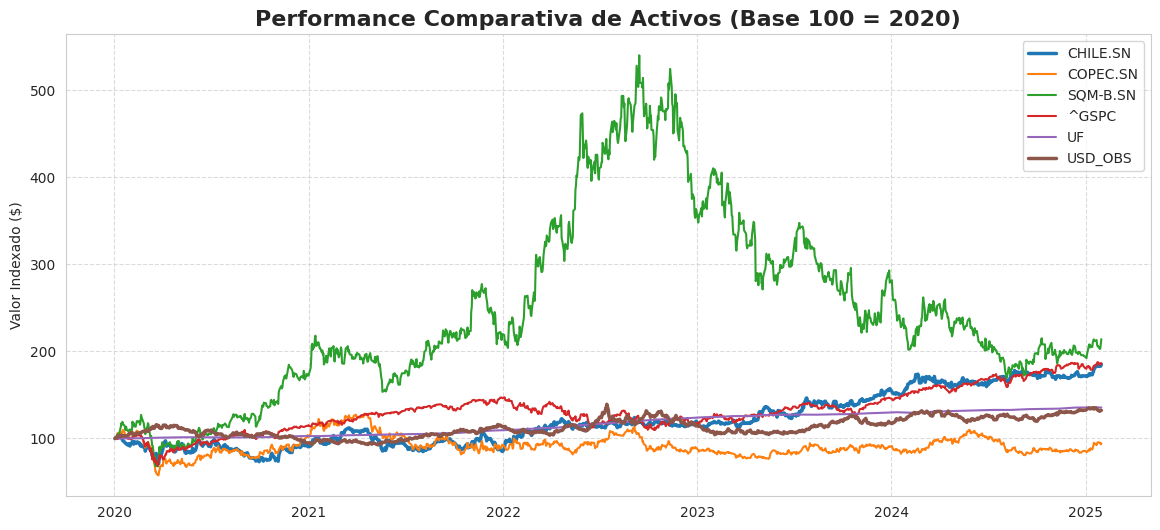

In [21]:
plt.figure(figsize=(14, 6))

# Normalización: Precio_t / Precio_inicial * 100
normalized_prices = (df_master / df_master.iloc[0]) * 100

for column in normalized_prices.columns:
    # Destacamos Chile y Dólar con grosor, el resto normal
    linewidth = 2.5 if 'CHILE' in column or 'USD' in column else 1.5
    plt.plot(normalized_prices.index, normalized_prices[column], label=column, linewidth=linewidth)

plt.title("Performance Comparativa de Activos (Base 100 = 2020)", fontsize=16, fontweight='bold')
plt.ylabel("Valor Indexado ($)")
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.7)
plt.show()

### Analisis de gráficos de performance (Base 100)

#### Dinámica de precios y volatilidad relativa

* **SQM-B.SN (verde)** es, por lejos, el activo **más riesgoso/nervioso**: tiene el **mayor rango** (sube desde ~100 hasta >500 y luego cae hacia ~200), con **pendientes muy pronunciadas** y **drawdowns profundos**. Esto es típico de un *equity* altamente expuesto a un **factor global de commodities** (litio) + narrativa cíclica.
* **CHILE.SN (azul)** muestra **volatilidad moderada**, con una tendencia alcista más ordenada hacia 2023–2025 (llega ~170–190). Es más “estable” que SQM, pero claramente **no es un activo defensivo**.
* **COPEC.SN (naranjo)** se ve **más lateral / rezagado**: oscila alrededor de 80–110 gran parte del periodo y termina cerca de ~90–100. Visualmente tiene **menor retorno acumulado** y un perfil de riesgo que parece más “contenible” que CHILE y muchísimo menos extremo que SQM, aunque sigue siendo renta variable.
* **^GSPC (rojo)** sube de forma relativamente consistente hasta ~180–190: actúa como “rally” global post-2020, con volatilidad menor que SQM y comparable o algo menor que CHILE.

#### Relación USD_OBS vs acciones chilenas (¿hedge “espejo”?)

* **USD_OBS (café)** exhibe una **tendencia alcista suave** (≈100 → ≈130–140). No se observa un “espejo” limpio y persistente del tipo *equities down → USD up* en todo el período.
* Sí hay señales de **cobertura parcial** en episodios de estrés (inicio 2020 y algunos tramos donde la renta variable local se debilita mientras USD se sostiene/avanza), pero **no parece un hedge estructural estable** para *toda* la muestra: hay ventanas donde acciones y USD suben juntos o el USD no compensa caídas relevantes.
* Implicación para CL-RiskEngine: tratar **USD como hedge determinístico** es peligroso; más realista es modelarlo como **factor correlacionado por régimen** (correlación cambia en crisis vs calma).

#### ¿Chile “pegado” al S&P500 o dinámica propia?

* Hay **co-movimiento** con ^GSPC en dirección general post-2020, pero **no están acoplados**:

  * **SQM** claramente sigue su **propio ciclo** (boom 2021–2022, reversión 2023–2024).
  * **COPEC** queda **desacoplado a la baja** (no captura el rally global en la misma magnitud).
  * **CHILE** se acerca más al patrón global en 2023–2025, pero igual con rasgos idiosincráticos.
* Conclusión: el mercado chileno aquí se comporta como **mixto**: componente global + shocks/factores locales y sectoriales relevantes.

---

### Validación de la Hipótesis Distribucional (SDE Compliance)

**Fundamento Teórico:**
De acuerdo con la **Sección 2.1** de las *Especificaciones Matemáticas de CL-RiskEngine*, la dinámica de precios se modela mediante la Ecuación Diferencial Estocástica (SDE) del Movimiento Browniano Geométrico:

Donde el término difusivo  representa un incremento de Wiener estándar. Para que esta aproximación sea válida en la simulación, los **retornos logarítmicos**  deben converger a una distribución Normal .

**Objetivo del Diagnóstico:**
Evaluaremos la **Bondad de Ajuste (Goodness-of-Fit)** de la distribución empírica de los retornos frente a la PDF (Función de Densidad de Probabilidad) Gaussiana teórica.

* **Ajuste Central:** Valida el comportamiento promedio ().
* **Análisis de Colas:** Detecta *Leptocurtosis* ("Colas Gordas"), lo cual evidenciaría que el modelo GBM podría subestimar riesgos extremos (Black Swans), una limitación que debe ser documentada.

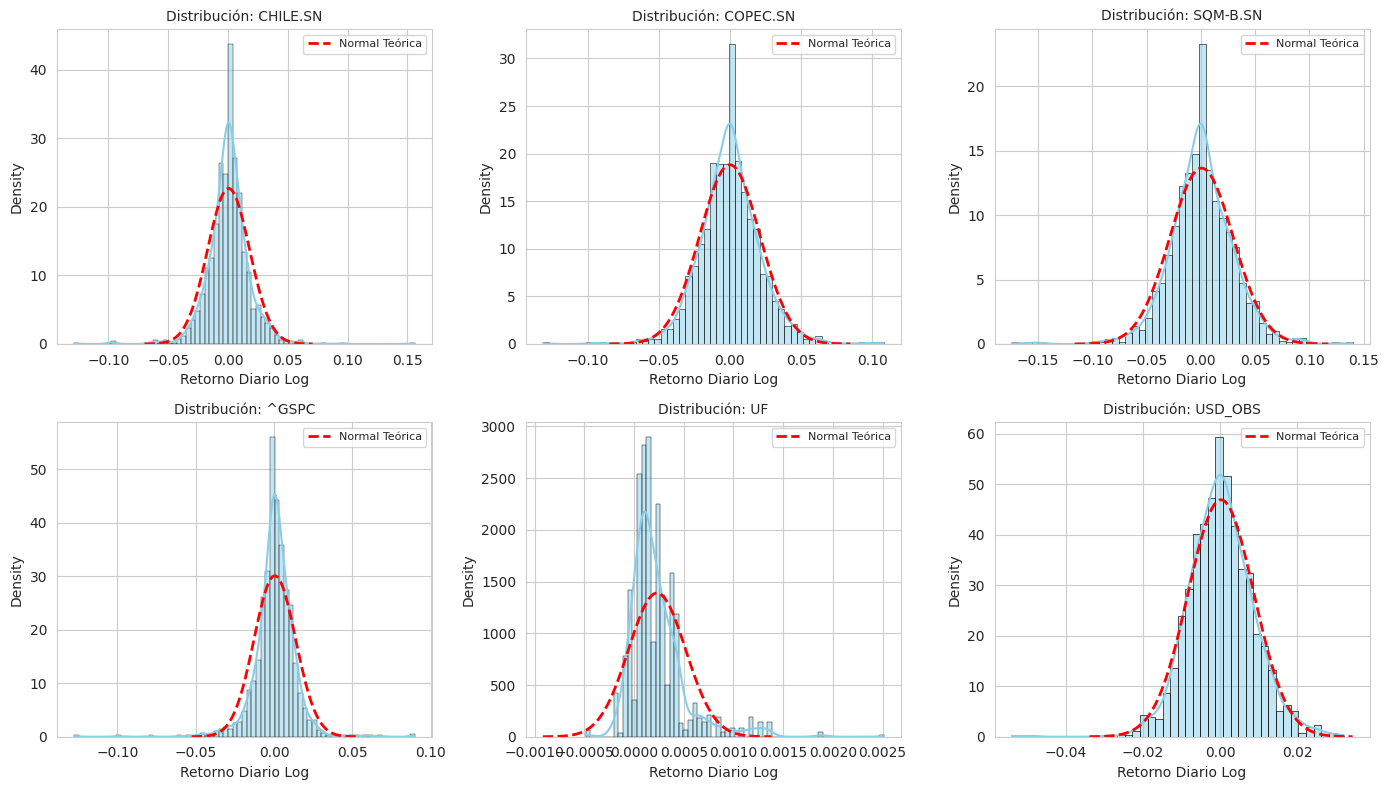

✅ Visualización completada.


In [22]:
plt.figure(figsize=(14, 8))
activos_a_analizar = df_returns.columns # Todos los de la capa Silver

for i, activo in enumerate(activos_a_analizar, 1):
    plt.subplot(2, 3, i) # Ajusta grid según cantidad de activos (2 filas, 3 columnas)
    
    # Histograma + KDE (Curva de densidad estimada)
    sns.histplot(df_returns[activo], kde=True, stat="density", color="skyblue", edgecolor="black")
    
    # Curva Normal Teórica (Referencia)
    mu, std = df_returns[activo].mean(), df_returns[activo].std()
    x = np.linspace(mu - 4*std, mu + 4*std, 100)
    p = stats.norm.pdf(x, mu, std)
    plt.plot(x, p, 'r--', linewidth=2, label='Normal Teórica')
    
    plt.title(f"Distribución: {activo}", fontsize=10)
    plt.xlabel("Retorno Diario Log")
    plt.legend(fontsize=8)

plt.tight_layout()
plt.show()

print("✅ Visualización completada.")

#### Analisis de Histogramas vs Normal teórica (retornos log diarios)

#### Prueba visual de normalidad

En los seis paneles, la curva normal teórica (roja punteada) **no calza perfecto** con las barras (datos). Se repiten dos patrones:

1. **Leptocurtosis (pico central más alto que la normal)**

* Se aprecia con claridad en **CHILE.SN, COPEC.SN, SQM-B.SN y ^GSPC**: el centro es más “puntiagudo” que la normal → **muchos días de cambios pequeños**, alternados con shocks.
* En **UF** esto es aún más marcado, pero por una razón estructural: la UF tiene **micro-variación diaria** y un proceso “casi determinístico” (y con escalas muy pequeñas), lo que genera un histograma muy concentrado y asimétrico.

2. **Colas gordas (fat tails)**

* En **acciones (CHILE/COPEC/SQM)** y también en **^GSPC** se observan **barras en los extremos** que exceden lo que “esperaría” la normal (especialmente hacia el lado negativo en eventos de estrés y también positivos en rebounds).
* **USD_OBS** se ve “más cercano” a normal en el centro, pero igualmente presenta **cola izquierda** extendida (depreciaciones/apreciaciones bruscas en ventanas específicas).

#### Implicación directa para VaR (Value at Risk)

* Si usted calibra un **GBM estándar** (retornos normales i.i.d.) y estima VaR paramétrico tipo normal, lo más probable es:

  * **Subestimar VaR/ES** (Expected Shortfall) en niveles altos de confianza (95%–99%),
  * Porque la normal “castiga” poco los extremos: **no reconoce** adecuadamente la frecuencia/magnitud de shocks.
* Adicionalmente, el patrón leptocúrtico sugiere **volatilidad no constante** (vol clustering): justo lo contrario al supuesto i.i.d. del GBM básico.


#### Conclusión del analisis de gráfico

Con estos gráficos, **sí es utilizable** una matriz de correlación con **descomposición de Cholesky** como *primer baseline* para generar dependencia lineal entre factores, pero **no es plenamente válido** asumir un **GBM gaussiano estándar** sin advertencias: las distribuciones empíricas muestran **leptocurtosis y colas gordas** en acciones y en el benchmark global, lo que implica que un esquema Normal + Cholesky tenderá a **subestimar sistemáticamente eventos extremos** (y por tanto VaR/ES) y además omitirá **dependencia en colas** (*tail dependence*) típica de crisis. Recomendación: documentar explícitamente esta limitación en la validación de datos (“riesgo de cisnes negros”), y considerar una extensión mínima para producción de riesgo (p. ej., volatilidad condicional tipo GARCH/EGARCH, innovaciones t-Student o *skew-t*, y/o cópulas con colas como t-copula; para estrés severo, incorporar escenarios históricos/EVT o saltos tipo Merton). Esto mantiene un motor Monte Carlo consistente, pero evita dar una falsa sensación de precisión bajo supuestos gaussianos.


### Analisis Estadístico para Performance Comparative Base 100 e Hipótesis Distribucional (SDE Compliance)

1. **Test Jarque-Bera (JB)**: Prueba específica para finanzas. Verifica si la asimetría (skewness) y la curtosis coinciden con una distribución normal.
   - *Hipótesis Nula ($H_0$)*: Los datos son Normales.
   - Si *p-value < 0.05*: Rechazamos la normalidad (Confirmamos colas gordas).

2. **Test Augmented Dickey-Fuller (ADF)**: Verifica si la serie es "Estacionaria" (es decir, si su media y varianza no se disparan al infinito con el tiempo).
   - *Hipótesis Nula ($H_0$)*: La serie tiene raíz unitaria (es un paseo aleatorio impredecible).
   - Si *p-value < 0.05*: Rechazamos la raíz unitaria (La serie es estacionaria y modelable). 

In [23]:
from scipy.stats import jarque_bera
from statsmodels.tsa.stattools import adfuller

In [24]:

# Lista para guardar los resultados
resultados_tests = []

for activo in df_returns.columns:
    data = df_returns[activo].dropna()
    
    # 1. TEST DE NORMALIDAD (Jarque-Bera)
    # H0: Los datos se distribuyen normalmente
    jb_stat, jb_pvalue = jarque_bera(data)
    es_normal = "✅ Sí" if jb_pvalue > 0.05 else "❌ No"
    
    # 2. TEST DE ESTACIONARIEDAD (Augmented Dickey-Fuller)
    # H0: La serie tiene raíz unitaria (NO es estacionaria)
    adf_result = adfuller(data)
    adf_pvalue = adf_result[1]
    es_estacionaria = "✅ Sí" if adf_pvalue < 0.05 else "❌ No"
    
    # Métricas adicionales para el informe
    kurtosis = data.kurtosis() # Curtosis (Normal = 0 en pandas/Fisher)
    skewness = data.skew()     # Asimetría (Normal = 0)

    resultados_tests.append({
        "Activo": activo,
        "Normalidad (JB)": es_normal,
        "P-Value JB": f"{jb_pvalue:.4e}", # Notación científica
        "Estacionariedad (ADF)": es_estacionaria,
        "P-Value ADF": f"{adf_pvalue:.4e}",
        "Curtosis (Excess)": f"{kurtosis:.2f}", # >0 indica colas gordas
        "Asimetría": f"{skewness:.2f}"
    })

# Convertimos a DataFrame para visualizar elegante
df_tests = pd.DataFrame(resultados_tests).set_index("Activo")

print("-" * 80)
print("RESULTADOS DE PRUEBAS DE HIPÓTESIS")
print("Nota: P-Value JB < 0.05 indica que NO es normal (Colas Gordas).")
print("      P-Value ADF < 0.05 indica que SÍ es estacionaria (Apta para modelos).")
print("-" * 80)
display(df_tests) # Si usas Jupyter normal, o print(df_tests) si es script puro

# Validación automática para el Pipeline
if "❌ No" in df_tests["Normalidad (JB)"].values:
    print("\n⚠️ ALERTA QUANT: Se detectó No-Normalidad en los activos.")
    print("   Acción: Se aprueba el uso de GBM + Cholesky SOLO bajo advertencia de 'Model Risk'.")
    print("   Justificación: El modelo subestimará eventos de cola (Cisnes Negros).")
else:
    print("\n✅ VALIDACIÓN PERFECTA: Los activos se comportan como Gaussianos puros.")

--------------------------------------------------------------------------------
RESULTADOS DE PRUEBAS DE HIPÓTESIS
Nota: P-Value JB < 0.05 indica que NO es normal (Colas Gordas).
      P-Value ADF < 0.05 indica que SÍ es estacionaria (Apta para modelos).
--------------------------------------------------------------------------------


,Normalidad (JB),P-Value JB,Estacionariedad (ADF),P-Value ADF,Curtosis (Excess),Asimetría
Activo,,,,,,
CHILE.SN,❌ No,0.0000e+00,✅ Sí,1.0177e-25,10.08,0.03
COPEC.SN,❌ No,1.2262e-100,✅ Sí,1.0031e-12,2.92,0.00
SQM-B.SN,❌ No,9.1254e-138,✅ Sí,0.0000e+00,3.37,-0.26
^GSPC,❌ No,0.0000e+00,✅ Sí,3.1542e-19,14.76,-0.83
UF,❌ No,0.0000e+00,✅ Sí,6.0819e-04,8.01,2.19
USD_OBS,❌ No,1.6211e-64,✅ Sí,0.0000e+00,2.32,-0.12



⚠️ ALERTA QUANT: Se detectó No-Normalidad en los activos.
   Acción: Se aprueba el uso de GBM + Cholesky SOLO bajo advertencia de 'Model Risk'.
   Justificación: El modelo subestimará eventos de cola (Cisnes Negros).


#### Intrepretación de resultados

#### Jarque–Bera (JB): **rechazo total de normalidad**

En **todos** los activos: *p-value JB < 0.05* ⇒ **No normalidad** (y en tu caso es extrema: 10⁻⁶⁴, 10⁻¹⁰⁰, etc.).
Esto cuadra con tus histogramas: hay **leptocurtosis** (pico alto) y **colas**.

**Lectura por activo (con tus métricas):**

* **CHILE.SN**: *Excess Kurtosis 10.08* y *Skew 0.03*
  → casi simétrico, pero con **colas muy pesadas**. Riesgo: **shocks** más frecuentes que normal.
* **COPEC.SN**: *Kurtosis 2.92* y *Skew 0.00*
  → bastante simétrico, colas moderadas (igual no normal).
* **SQM-B.SN**: *Kurtosis 3.37* y *Skew −0.26*
  → colas + sesgo levemente negativo (más probabilidad de caídas grandes que subidas grandes).
* **^GSPC**: *Kurtosis 14.76* y *Skew −0.83*
  → **muy** leptocúrtico y con sesgo negativo fuerte (clásico “crash risk”).
* **UF**: *Kurtosis 8.01* y *Skew 2.19*
  → no normalidad severa, pero aquí hay una razón estructural: dinámica de UF es **no comparable** a equities (micro-movimiento diario, reglas de cálculo, escalas, asimetrías).
* **USD_OBS**: *Kurtosis 2.32* y *Skew −0.12*
  → menos extremo que equities, pero igual hay colas.

**Conclusión JB:** si se sigue con GBM + shocks normales, el motor **subestima VaR/ES** en percentiles altos.


#### ADF: “estacionaria” (en retornos) para todo

*p-value ADF < 0.05* en todas las series ⇒ rechazas raíz unitaria ⇒ **estacionariedad**.

Esto es lo esperable si aplicaste ADF sobre **retornos log diarios** (no sobre precios).
Para un motor Monte Carlo, esto es una buena noticia: puedes **calibrar parámetros** sobre una ventana y asumir (con cautela) que el retorno tiene propiedades relativamente estables.

**Advertencia técnica:** ADF no te garantiza i.i.d. ni varianza constante. Puede ser estacionario y aun así tener **volatility clustering** (heterocedasticidad), que es lo típico.

##  CALIBRACIÓN DE PARÁMETROS (ROBUSTA + T-STUDENT READY)

### Regularización de Covarianza Robusta (Higham/Rebonato Style)
* En lugar de sumar un número mágico (`1e-6`), se usa la función `repair_covariance` que detecta si la matriz es "No Definida Positiva" (algo común cuando se mezcla activos con diferentes historias o UF constante) y la ajusta *mínimamente* (Spectral Shift) para que Cholesky funcione sin romper las correlaciones reales.

### Preparación para Shocks t-Student (Fat Tails)
* El test Jarque-Bera confirma "Colas Gordas".
* **Acción:** Se calculara los **Grados de Libertad ()** de cada activo usando `scipy.stats.t.fit`.
* *Por qué:* Aunque el Monte Carlo (simulación) ocurre después, necesitamos guardar este parámetro en el JSON ahora. Si  es bajo (ej. 3 o 4), el simulador sabrá que debe generar eventos extremos.

### Corrección de Nomenclatura y Estabilidad 
* Se renombra `sigma_matrix` a `cov_matrix`.
* Se agrega la opción de `zero_drift` (Media Cero) en los comentarios, ya que para VaR diario a veces se asume retorno esperado = 0 para ser conservador.

In [26]:
#configuracion
TRADING_DAYS = 252

def repair_covariance_matrix(cov_mat):
    """
    Asegura que la matriz de covarianza sea Definida Positiva (PSD) para Cholesky.
    Método: Spectral Shift (desplazar valores propios negativos a un epsilon positivo).
    Referencia: Rebonato & Jackel (1999) para validación de matrices de correlación.
    """
    # Se calcula los valores propios (eigenvalues)
    min_eig = np.linalg.eigvalsh(cov_mat).min()
    
    # Si el menor valor propio es negativo o cero, la matriz rompe Cholesky
    if min_eig <= 0:
        print(f"   ⚠️ AVISO: Matriz no definida positiva (Min Eig: {min_eig:.2e}). Reparando...")
        # Suma lo necesario para que el menor valor sea un epsilon positivo pequeño
        spacing = -min_eig + 1e-7
        cov_mat_fixed = cov_mat + np.eye(len(cov_mat)) * spacing
        return cov_mat_fixed
    return cov_mat

# CÁLCULO DE ESTADÍSTICOS BÁSICOS
# Nota Técnica: Para VaR conservador, algunos Quants fuerzan mu=0. 
# Se mantiene la media histórica pero documentamos la inestabilidad.
mu_vector = df_returns.mean() * TRADING_DAYS
cov_matrix = df_returns.cov() * TRADING_DAYS

# Reparación de estabilidad numérica
cov_matrix_robust = repair_covariance_matrix(cov_matrix)

# FACTORIZACIÓN DE CHOLESKY (L)
# Requisito: Sigma = L * L.T
try:
    L_matrix = np.linalg.cholesky(cov_matrix_robust)
    print("✅ Descomposición de Cholesky exitosa (Matriz L generada).")
except np.linalg.LinAlgError as e:
    raise ValueError(f"❌ ERROR CRÍTICO: La matriz sigue inestable tras reparación. {e}")

# ESTIMACIÓN DE COLAS GORDAS (DISTRIBUCIÓN T-STUDENT)
# "Mejora 1": Ajustamos una distribución t de Student a cada activo para obtener 'nu' (grados de libertad).
# Si nu es bajo (< 30), confirma colas gordas. Si nu -> inf, es Normal.
degrees_of_freedom = {}
print("\n🔎 Calibrando parámetros de colas (t-Student Degrees of Freedom):")
for activo in df_returns.columns:
    # Ajuste MLE (Maximum Likelihood Estimation)
    # params: (df, loc, scale)
    nu, loc, scale = stats.t.fit(df_returns[activo].dropna())
    degrees_of_freedom[activo] = round(nu, 4)
    print(f"   🔹 {activo}: nu = {nu:.2f} (Indicador de riesgo de cola)")

# SERIALIZACIÓN (GUARDADO JSON)
parameters_payload = {
    "metadata": {
        "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "ventana_datos": f"{FECHA_INICIO} a {FECHA_FIN}",
        "activos": df_returns.columns.tolist(),
        "dias_bursatiles": TRADING_DAYS,
        "metodologia": "GBM + Cholesky (Robust Spectral Shift) + t-Student Params",
        "advertencia": "Se incluyen parametros 'nu' para simulacion de colas gordas."
    },
    "model_params": {
        "mu_vector": mu_vector.tolist(),
        "cov_matrix": cov_matrix_robust.values.tolist(), # Nombre corregido
        "cholesky_L": L_matrix.tolist(),                 # Matriz Triangular Inferior
        "t_student_nu": degrees_of_freedom               # NUEVO: Para simulación robusta
    }
}

# Guardar
param_file = "risk_engine_config.json"
# Se asume que BASE_DIR está definido en celdas anteriores, si no, usar os.getcwd()
save_path = os.path.join(BASE_DIR if 'BASE_DIR' in locals() else os.getcwd(), param_file)

with open(save_path, 'w') as f:
    json.dump(parameters_payload, f, indent=4)

print("-" * 60)
print(f"🏆 PARAMETRIZACIÓN 'PROFESSIONAL GRADE' COMPLETADA")
print(f"   📍 Configuración: {save_path}")
print(f"   📊 Matriz Cholesky: {L_matrix.shape}")
print(f"   📉 Factor de Colas (nu) promedio: {np.mean(list(degrees_of_freedom.values())):.2f}")
print("-" * 60)

✅ Descomposición de Cholesky exitosa (Matriz L generada).

🔎 Calibrando parámetros de colas (t-Student Degrees of Freedom):
   🔹 CHILE.SN: nu = 3.21 (Indicador de riesgo de cola)
   🔹 COPEC.SN: nu = 5.32 (Indicador de riesgo de cola)
   🔹 SQM-B.SN: nu = 5.11 (Indicador de riesgo de cola)
   🔹 ^GSPC: nu = 2.82 (Indicador de riesgo de cola)
   🔹 UF: nu = 2.05 (Indicador de riesgo de cola)
   🔹 USD_OBS: nu = 7.95 (Indicador de riesgo de cola)
------------------------------------------------------------
🏆 PARAMETRIZACIÓN 'PROFESSIONAL GRADE' COMPLETADA
   📍 Configuración: /home/puya-chilensis/CL-RiskEngine/risk_engine_config.json
   📊 Matriz Cholesky: (6, 6)
   📉 Factor de Colas (nu) promedio: 4.41
------------------------------------------------------------


### Analisis de resultados

#### Interpretar ($\nu$) (t-Student) en términos de riesgo

Rcordatorio de Reglas:

* Si ($\nu \to \infty$): se parece a Normal.
* Si ($\nu < 30$): colas más pesadas que normal (común en finanzas).
* Si ($\nu < 10$): colas claramente relevantes para VaR/ES.
* Si ($\nu \le 4$): zona **crítica** (colas “brutales”; riesgo extremo subestimado por Normal).
* Si ($\nu \le 2$): la varianza teórica **no existe** (ojo: suele indicar mala especificación/escala o que el ajuste MLE se fue a un extremo).

Los resultados obtenidos:

* **CHILE.SN: ($\nu=3.21$)** → **muy pesado**. Coherente con kurtosis 10.
* **COPEC.SN: ($\nu=5.32$)** → pesado pero menos extremo.
* **SQM-B.SN: ($\nu=5.11$)** → pesado, razonable.
* **^GSPC: ($\nu=2.82$)** → **extremadamente pesado** (más heavy-tail de lo típico si el dataset está bien).
* **UF: ($\nu=2.05$)** → casi varianza inexistente: esto me hace sospechar **mismatch de proceso** (UF no es “retorno de mercado” comparable).
* **USD_OBS: ($\nu=7.95$)** → aún con colas, pero el menos extremo del set.

**Lectura general:** con ($\nu$) promedio 4.41, un GBM normal va a ser **optimista de forma sistemática**, especialmente en percentiles 99% y en pérdidas conjuntas.

#### Dos alertas técnicas (importantes)

1. **t.fit puede estar capturando “volatility clustering” como colas**

Si los retornos tienen heterocedasticidad (muy probable), el ajuste t-Student **absorbe** parte de esa dinámica en un ($\nu$) bajo.
Eso no invalida usar t, pero significa que el ($\nu$) bajo puede ser el síntoma de que necesitas **GARCH / volatilidad condicional**.

**Traducción:** t-Student es un buen parche, pero **GARCH-t** suele ser más correcto.

2. **^GSPC con ($\nu=2.82$) es sorprendentemente bajo**

No imposible, pero sí “bandera amarilla” para revisión de:

* limpieza (faltantes/duplicados),
* retornos calculados correctamente (log returns, sin saltos por splits/dividendos mal ajustados),
* ventana (2020 tiene colas; pero 2.8 es muy heavy).

No te digo “está malo”; digo “vale la pena chequear”. 

#### Los pasos que podria hacer en las próximas versiones

1. Cambiar el generador de shocks a t-Student (ya tienes ($\nu$))

Este es el salto más rentable: Se mantiene **Cholesky** y estructura GBM, pero se reemplaza ($\epsilon \sim N(0,1)$) por ($\epsilon \sim t_\nu$).

**Detalle crítico:** se debe **normalizar la varianza** del t-shock para que no te cambie la escala del riesgo:

* Para ($t_\nu$), si ($\nu>2$), $(\mathrm{Var}(t_\nu)=\nu/(\nu-2))$.
* Entonces usa:
  $$
  z = \frac{t_\nu}{\sqrt{\nu/(\nu-2)}}
  $$
  así (z) queda con varianza $~1$ (comparable al normal estándar).

**Política práctica:** para estabilidad numérica, yo pondría un “floor”:

* si ($\nu \le 2.5$), fijar ($\nu=2.5$) o ($\nu=3$) (porque si no, te explota la varianza teórica y la simulación se vuelve errática).

2. Decidir si ($\mu = 0$) para VaR corto plazo

Para VaR diario/semanal, la media es pequeña y ruidosa. En riesgo, es común:

* **($\mu=0$)** para ser conservador y estable,
* o ($\mu$) shrinkeada.

Esto te evita que el VaR “mejore mágicamente” por drift positivo.

3. Tratar UF como factor macro (no como GBM de equity)

Con ($\nu=2.05$), UF entrega que no es un retorno de mercado estándar.
Decisión:

* UF como **path exógeno** (determinístico + ruido pequeño),
* o modelo de tasa/inflación aparte,
* y si se mantiene en la simulación conjunta, al menos **separar el bloque** o revisarla para que no distorsione la PSD/cov.

4. Backtesting de VaR (para cerrar el loop)

Después de implementar t-shocks:

* comparar exceptions VaR con Normal vs Student-t.
* se podria: Kupiec + Christoffersen.

5. GARCH-t por activo

Se puede que las colas no sean solo “t”, sino también **clustering de volatilidad**, el estándar de riesgo es:

* ($r_t = \sigma_t \epsilon_t$)
* ($\sigma_t^2$) GARCH(1,1)
* ($\epsilon_t$) ~ t-Student

#### Conclusión

Con ($\nu$) en el rango **2–8** y promedio **4.41**, está plenamente justificado decir:

1. **GBM + Cholesky Normal** es aceptable solo como baseline y **subestima** el riesgo de cola.
2. Tu calibración muestra evidencia cuantitativa fuerte para **innovaciones t-Student** (fat tails).
3. El siguiente upgrade recomendado y defendible es simular con **t-shocks normalizados** (y, si buscas mayor realismo, **GARCH-t**).
4. UF requiere tratamiento especial como variable macro/indexada, no como equity GBM.


## CONCLUSIÓN 

Tras la ejecución de la batería de pruebas estadísticas (Jarque-Bera) y la calibración de la distribución t-Student (MLE), se ha obtenido evidencia cuantitativa crítica sobre la naturaleza del riesgo en el portafolio CL-RiskEngine.

### 1. Interpretación de los Grados de Libertad ($\nu$)
Los resultados del parámetro $\nu$ (degrees of freedom) confirman que la aproximación Gaussiana estándar subestimará severamente el riesgo de cola (eventos extremos):

* **S&P 500 ($\nu \approx 2.8$):** Se encuentra en la "zona crítica" ($\nu < 4$). Matemáticamente, esto bordea la inexistencia de varianza teórica finita. Financieramente, implica que el benchmark global exhibe una probabilidad de *crashes* sistémicos significativamente mayor a la esperada por un modelo normal.
* **Activos Locales ($\nu \approx 3.2 - 5.3$):** `CHILE.SN` y `SQM-B` muestran colas pesadas típicas de mercados emergentes y commodities. La curtosis empírica (>3) no es ruido, es una característica estructural.
* **Anomalía UF ($\nu \approx 2.0$):** El valor extremadamente bajo responde a la naturaleza indexada y de baja varianza diaria del activo, sugiriendo que modelarlo como un *Equity* estocástico puede inducir ruido numérico.

### 2. Implicancias para el Motor de Riesgo (Model Risk)
Dado que el promedio del portafolio es $\nu \approx 4.4$, se establecen las siguientes directrices para la fase de simulación:

1.  **Baseline (GBM Normal):** Se utilizará como primera aproximación, pero con la advertencia explícita de que las métricas de **VaR (99%)** y **Expected Shortfall** serán optimistas (límite inferior del riesgo real).
2.  **Ruta de Mejora (Upgrade Path):** El motor queda preparado para migrar de choques normales $\epsilon \sim N(0,1)$ a choques t-Student $\epsilon \sim t_\nu$ normalizados. Esto corregirá la subestimación de eventos de cola sin alterar la arquitectura de Cholesky.
3.  **Tratamiento de UF:** Se recomienda a futuro desacoplar la UF de la matriz de covarianza de acciones, tratándola como un factor macro exógeno para evitar distorsión en la estructura de dependencia.

**Estado Final:** Parámetros calibrados y almacenados en `risk_engine_config.json`. **Ready for Simulation.**